# Simulating Shoreline Change using Coupled Coastsat and Coastline Evolution Model (CEM) - Part 2


#### In this lab users will extract a satellite derived shoreline in a location of their choosing. They will then evolve this shoreline using the Coastal Evolution model. They will be able to tune wave characteristics and explore the role of dominant wave climate in producing longterm change of an area relevant to their interests. 

#### Part 1 of the lab extracts all historical observations and prepares them for input into the CEM
#### Part 2 of the lab uses the CEM to evolve the extracted shoreline

Important references:

1. Ashton, A.D., Murray, B., Arnault, O. 2001. Formation of coastline features by large-scale instabilities induced by high-angle waves, Nature 414.
2. Ashton A.D., Murray A.B. [High-Angle Wave Instability and Emergent Shoreline Shapes: 1. Wave Climate Analysis and Comparisons to Nature.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005JF000422) Journal of Geophysical Research. Volume 111. 15 December 2006. <br>
3. Ashton A.D., Murray A.B. [High-Angle Wave Instability and Emergent Shoreline Shapes: 2. Wave Climate Analysis and Comparisons to Nature.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005JF000423) Journal of Geophysical Research. Volume 111. 15 December 2006.
4. Vos K., Splinter K.D., Harley M.D., Simmons J.A., Turner I.L. (2019). CoastSat: a Google Earth Engine-enabled Python toolkit to extract shorelines from publicly available satellite imagery. Environmental Modelling and Software. 122, 104528. https://doi.org/10.1016/j.envsoft.2019.104528 (Open Access)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import path
%matplotlib inline
import pandas as pd
from scipy import stats,signal
from IPython.display import clear_output

from pymt.models import Cem, Waves
import buoypy as bp
import runmodels_functions as fun

➡ models: Avulsion, Plume, Sedflux3D, Subside, Rafem, PRMSSurface, PRMSStreamflow, PRMSSoil, PRMSGroundwater, FrostNumber, Ku, Hydrotrend, GIPL, ECSimpleSnow, Cem, Waves


### 1. Load Shoreline Data from CoastSAT & NDBC Buoy Wave Data

These workflows are derived from the "Extract Wave Data" & "Convert CoastSat shoreline to grid for CEM" sections in the CoastSat & Wave Data notebook. Please see that file for more information on these processes.

First, let's get our wave data:

In [2]:
#From previous nb
Hs, Tp, Dir = 0.486, 3.156, 214.

We will be using the significant wave height (Hs), wave period (Tp), and wave direction (Dir) data from the NDBC buoy as inputs into the WAVES model. Now let's look at our shoreline:

Load in the shoreline from the last notebook--like we did in section 1.3:

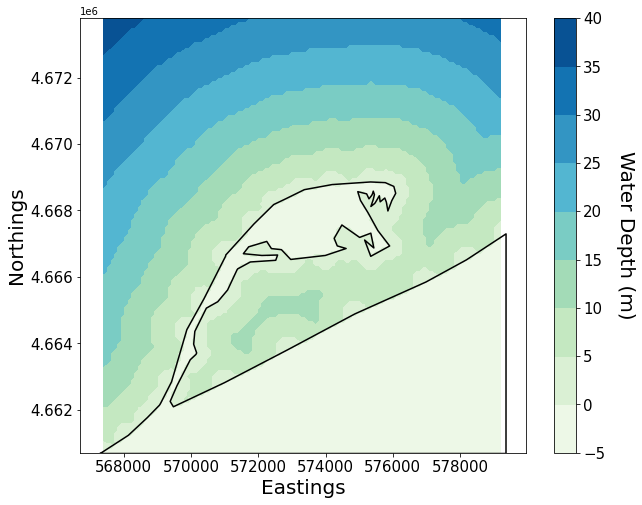

In [3]:
# gridded shoreline data
xy = np.loadtxt('data/Erie_example/Erie_spit_ESPIn.xy')

x=xy[:,0]  # x-coords
y=xy[:,1]  # y-coords

## grid spacing in [meters]
dx=100 
dy=100

fun.shorelinetogrid(x,y,dx,dy,plotdata=True);

### 1.2 Shoreline Orientation

This step is important!
The CEM runs with the shoreline oriented such that the open ocean is towards the top of the screen and the shoreline towards the bottom. The CEM boundaries are periodic in the east-west direction (relative to your screen), meaning that sediment and wave energy that crosses the right most boundary goes straight to the left most boundary. Because of this, it is important to try and line up the east-west shoreline edges on approximately the same latitude line/row of grid cells.


The example below rotates the shoreline to be compatible with the CEM boundary conditions described above:

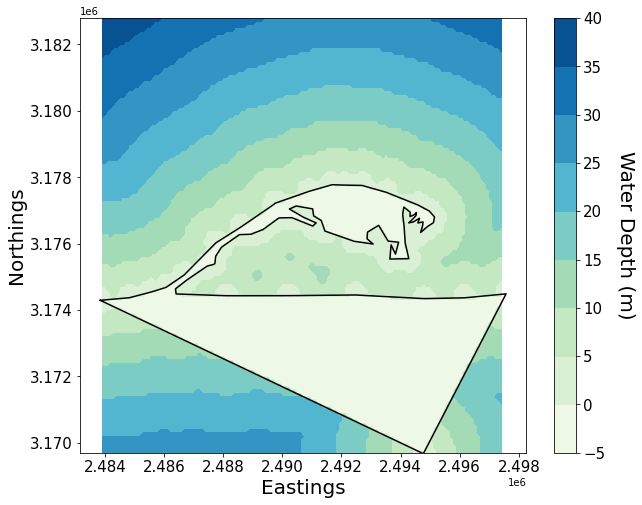

In [4]:
## here we are rotating the shoreline -25 degrees
a = -25*np.pi/180
# using this roation matix
x = (x ) * np.cos(a) - (y ) * np.sin(a)  
y = (x ) * np.sin(a) + (y ) * np.cos(a) 

[xg,yg,elev] = fun.shorelinetogrid(x,y,dx,dy,plotdata=True);

This ^ is the orentation that the CEM prefers. Now lets clean up the domain some.

### 1.3 Domain Cleaning
Now we need to tidy up the rotated shoreline and also make the shore/shelf gradients smoother for CEM to calculate the shore/self slopes.
The former is done by simly assigning all grid cells below the shorelines edge a "shoreline" grid value. The smothing is done by a 2d convolution of the shoreface.

In [33]:
## defining the set_domain function so that we can easily re-initialize our domain after model runs

def set_domain():
    z_elev = elev.T # transpose of the elevations for CEM/plotting purposes

    z_elev[z_elev==-5] = -1 ## -5 is the "shoreline" flag from above.
    domain = -1*z_elev ## we want the domain to have values above sea-level to be >0 and below <0


    ##Trial and error steps:

    ## smooth the depths by averaging each cell in the domain by NxN of its neighbors
    neighs = np.ones([10,10])
    total = (10**2)
    domain = signal.convolve2d(domain,neighs/total,mode='same',boundary='symm')

    domain[z_elev==-1] = 1 ## our shoreline got smoothed out too. This fixes that and makes sure our land is at 1m above sea level


    domain[:47,:] = 1 ## Here is where we fix the cropped section from when we rotated the shoreline above
    ## "all values below row X are land (1m)"
    return domain

domain= set_domain()

Let's visualize this updated coastline data with the function `plot_coast`. This will confirm that we have effectively translated the spit into model space.

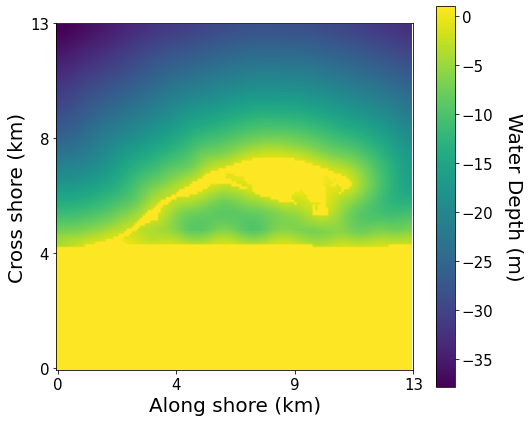

In [34]:
fun.plot_coast(domain,dx,dy)

Looks pretty similar! Notice how there is now a smooth gradient shoreface.

### 1.4 Shoreface/shelf Slope
Last step is to find the average shoreface and shelf slope--two CEM parameters. We will do this by appoximating a straight transect that extends from the beach off shore then using the equation from the last notebook to approximate the shelf slope:

In [35]:
h = lambda x: 0.1*x**(2/3) ## depth equation

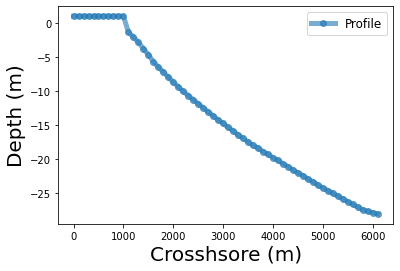

In [57]:
profile = np.copy(domain)[70:,80] ## find a nice straight column in the domain...
## whose depth gradient is towards the top of the domain
x = np.arange(len(profile))*dx ## the off shore coords in [meters]
 
plt.plot(x,profile,'-o',linewidth=5,alpha=0.6,label='Profile')
plt.legend(fontsize=12)
plt.ylabel('Depth (m)',fontsize=20)
plt.xlabel('Crosshsore (m)',fontsize=20)

## find the shoreline edge and approximate the gradient using the equation from the previous notebook:
x0 = x[11] ## edge point
xf = x[-1] ## open ocean depth

shelf_slope = (h(xf)-h(x0))/(xf-x0) 

##guessing the shoreface params because we dont have this data
shoreface_slope = 4*shelf_slope ## the shoreface is steeper than the shelf
shoreface_depth = 10 # depth meters

Now that we have processed the shoreline, we can initialize our models.

### 2. Model Setup
We are using the [Coastal Evolution Model (CEM)](https://csdms.colorado.edu/wiki/Model_help:CEM) and the [WAVES](https://csdms.colorado.edu/wiki/Model_help:Waves) models. The CEM simulates morphodynamic evolution of coastlines under varying wave climates. WAVES is the model that calculates the input wave energetics used in CEM as a function of wave period (T), deep water wave height (H<sub>0</sub>), and wave angle criteria. Run the help() commands on each function and read through their documentation.

In [58]:
cem = Cem()
waves = Waves()

In [59]:
## uncomment the lines below to see the model outlines

# help(cem)
# help(waves)

Check out the documentation online to get additional info on the parameters needed for each model:

[WAVES Documentation](https://csdms.colorado.edu/wiki/Model_help:Waves)

[CEM Documentation](https://csdms.colorado.edu/wiki/Model_help:CEM)

### 3.1. Initialize Models with Input Criteria
Here we are creating a _dictionary_ to assign value to our various input parameters for both the CEM and WAVES models. Defining CEM's parameter values this way facilitates transparency and easy manipulation of the variables. This dictionary will then be passed into the **initialize_models** function which sets up our models.

For our wave parameters, we are using the data from the "Extract Wave Data" section of the CoastSat notebook. Please see that file for more information on the data extraction.

*To convert wave direction to the **A** parameter, we use the following formula:*

$$\frac{|Dir-270|}{180}$$

*where **Dir** represents wave direction.*

In [60]:
#convert wave direction to asymmetry term
Ap = 1-float(abs(Dir-270)/180)

## We are using 1-Ap because the waves in our domain are coming from the left.

In [69]:
params = {
    
    ## CEM 
    'grid_spacing'    : dx,                #meters
    'shelf_slope'     : shelf_slope,
    'shoreface_depth' : shoreface_depth,   #meters
    'shoreface_slope' : shoreface_slope,
    'model__time_step': 1,               #days
    
    ##WAVES
    'sea_surface_water_wave__height' : Hs, #meters
    'sea_surface_water_wave__period' : Tp, #seconds
    'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter': 0.65, #important param
    'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter': Ap
    
}

In the CEM, cells can either be water or land. Land cells will have a uniform height that is greater than the water depth. They will only be affected by the coastal processes of alongshore sediment transport and wave action. Inland cells will not be affected. Water cells will have a set bathymetry that will respond to sediment supply and wave action. The model calculates the bathymetry through the inner shelf slope (`shelf_slope`), depth at which the shoreface ends (``shoreface_depth``), and the shoreface slope (``shoreface_slope``). We can take a look at an example [here](Example_run___SPITS.ipynb) showing how the CEM runs without an input shoreline.

We initialize the model with the `initialize_models` function.

In [70]:
#NOTE: You must re-run this cell to do another model run
domain = set_domain()
fun.initialize_models(params,domain,cem,waves)

Let's look at our input coastline again with the **plot_coast** function as our baseline. But now we use the BMI commant below to see if the CEM took our input and didnt do anything too crazy when it recalculates the slopes and depths.

We want to look at the input variable `land_surface__elevation` but this value is transformed into a 1d array in the model so we want to reshape it into the 2d array like our initial domain:

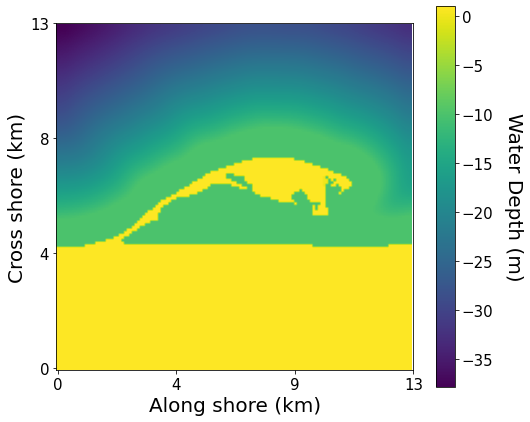

In [67]:
land = cem.get_value('land_surface__elevation')
land = land.reshape(  domain.shape  )

fun.plot_coast(land,dx,dy)

LOOKS GOOD! If you get any weirdness here go back up and smooth (convolve) the domain a bit more and try again. (I.e. average over more neighbors)

# RUN THE MODEL!
Here comes the fun part. Run the model using our pre-written `run_model_loop function`.
The `run_model_loop function` will run the CEM and can display an animation of the evolving shoreline. The first input expresses the model run time (in years). The function displays an animation by default but you can set `animate=False` to decrease model computation time.



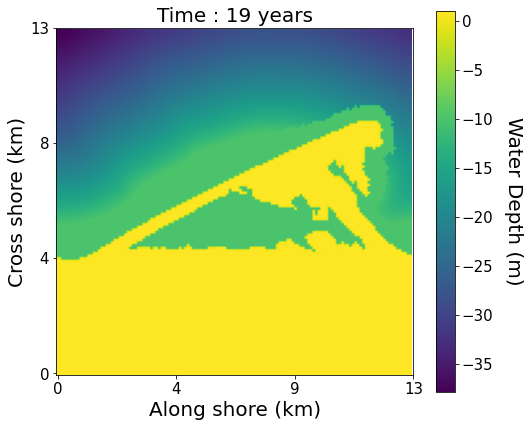

In [71]:

T = 20 #years
fun.run_model_loop(T,domain,cem,waves,update_ani_years=1/2)

Congratulations! We just ran the CEM on a real coastline input. Note that the simulation is somewhat unrealistic in that it does not take into account the resistance that humans/communities impose on shoreline change. However, if the shoreline we just simulated were completely unpopulated then we may well see such drastic change in real life--provided we used the correct input parameters.



<img src="Presque_Ilse_State_Park_9_10_2020.png" alt="Presque Ilse State Park" width="500"/>



Models rarely fully replicate all changes that happen in a real system due to various assumptions and important forcings neglected (i.e., storm events). Nevertheless, CEM does a pretty good job at simulating coastline change on a real spit.
### Now go back and re-run the CEM with different parameters!
Try changing the following one at a time and see what happens:

'shoreface_slope'
'shoreface_depth'

'sea_surface_water_wave__height',
'sea_surface_water_wave__period' 
'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter', 
'sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter'

#### HAVE FUN!